# **I - Naïve Bayes Sentiment Classification**

In this part 1 of the notebook, we will build a Naïve Bayes classifier to classify tweets as either positive or negative. The steps include preprocessing the data, building a frequency dictionary, training the model, and evaluating its performance.


## **1. Import Libraries**
First, we import the necessary libraries and download the required resources.



In [1]:
import re
import string
import numpy as np
from nltk.corpus import twitter_samples, stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
import nltk
from collections import defaultdict

In [2]:
nltk.download('twitter_samples')
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## **2. Load and Explore the Dataset**

We load the dataset of positive and negative tweets and explore its structure.

In [3]:
# Load the dataset
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

# Print dataset statistics
print(f"Number of positive tweets: {len(positive_tweets)}")
print(f"Number of negative tweets: {len(negative_tweets)}")
print("\nExample of a positive tweet:", positive_tweets[0])
print("Example of a negative tweet:", negative_tweets[0])

Number of positive tweets: 5000
Number of negative tweets: 5000

Example of a positive tweet: #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
Example of a negative tweet: hopeless for tmr :(


## **3. Preprocessing**

We define a function to preprocess tweets by removing special characters, tokenizing, removing stopwords, and stemming.

In [4]:
# Initialize tokenizer, stemmer, and stopwords
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
stemmer = PorterStemmer()
stopwords_english = stopwords.words('english')

In [5]:
def preprocess_tweet(tweet):
    """
    Preprocess a single tweet:
    1. Remove hyperlinks, special characters, and numbers
    2. Tokenize the tweet
    3. Remove stopwords and punctuation
    4. Perform stemming

    Args:
        tweet: String containing a tweet

    Returns:
        processed_tokens: List of processed tokens from the tweet
    """
    # Remove hyperlinks, special characters, and numbers
    tweet = re.sub(r'https?://[^\s]+', '', tweet)  # Remove hyperlinks
    tweet = re.sub(r'@[^\s]+', '', tweet)  # Remove @mentions
    tweet = re.sub(r'#', '', tweet)  # Remove hashtag symbol
    tweet = re.sub(r'[0-9]+', '', tweet)  # Remove numbers

    # Tokenize
    tokens = tokenizer.tokenize(tweet)

    # Remove stopwords and punctuation, then apply stemming
    processed_tokens = []
    for word in tokens:
        if (word not in stopwords_english and
            word not in string.punctuation and
            len(word) > 1):  # Remove single characters
            # Stemming
            stemmed_word = stemmer.stem(word)
            processed_tokens.append(stemmed_word)

    return processed_tokens

## **4. Build Frequency Dictionary**
We create a frequency dictionary to count how often each word appears in positive and negative tweets.

In [6]:
def build_freqs(tweets, labels):
    """
    Build a dictionary mapping tokens to their frequencies in each class
    """
    freqs = defaultdict(int)
    for tweet, label in zip(tweets, labels):
        for token in preprocess_tweet(tweet):
            freqs[(token, label)] += 1
    return freqs

In [7]:
# Prepare the dataset
all_tweets = positive_tweets + negative_tweets
labels = [1] * len(positive_tweets) + [0] * len(negative_tweets)

In [8]:
# Shuffle the dataset
np.random.seed(42)
shuffle_indices = np.random.permutation(len(all_tweets))
all_tweets = [all_tweets[i] for i in shuffle_indices]
labels = [labels[i] for i in shuffle_indices]

In [9]:
# Build the frequency dictionary
freqs = build_freqs(all_tweets, labels)

## **5. Naïve Bayes Classifier**

We define the Naïve Bayes classifier, including methods for training and prediction.

In [10]:
class NaiveBayes:
    def __init__(self):
        self.logprior = 0
        self.loglikelihood = {}

    def train(self, freqs, train_x, train_y):
        """
        Train the Naive Bayes classifier
        """
        vocab = set([word for (word, _) in freqs.keys()])
        V = len(vocab)

        N_pos = sum(freqs[(word, 1)] for word in vocab)
        N_neg = sum(freqs[(word, 0)] for word in vocab)

        D = len(train_y)
        D_pos = sum(train_y)
        D_neg = D - D_pos

        self.logprior = np.log(D_pos / D_neg)

        for word in vocab:
            freq_pos = freqs.get((word, 1), 0)
            freq_neg = freqs.get((word, 0), 0)
            p_w_pos = (freq_pos + 1) / (N_pos + V)
            p_w_neg = (freq_neg + 1) / (N_neg + V)
            self.loglikelihood[word] = np.log(p_w_pos / p_w_neg)

    def predict(self, tweet):
        """
        Predict the sentiment of a tweet
        """
        word_list = preprocess_tweet(tweet)
        p = self.logprior
        for word in word_list:
            if word in self.loglikelihood:
                p += self.loglikelihood[word]
        return p > 0

    def evaluate(self, test_x, test_y):
        """
        Evaluate the model on a test set
        """
        correct = 0
        for tweet, label in zip(test_x, test_y):
            prediction = self.predict(tweet)
            if prediction == (label == 1):
                correct += 1
        return correct / len(test_y)

## **6. Train and Evaluate the Model**

We split the dataset into training and testing sets, train the model, and evaluate its accuracy.

In [11]:
# Split into train and test sets (80% train, 20% test)
split_idx = int(0.8 * len(all_tweets))
train_x = all_tweets[:split_idx]
train_y = labels[:split_idx]
test_x = all_tweets[split_idx:]
test_y = labels[split_idx:]

In [12]:
# Train the Naive Bayes model
nb_model = NaiveBayes()
nb_model.train(freqs, train_x, train_y)

In [13]:
# Test the model
correct = 0
for tweet, label in zip(test_x, test_y):
    prediction = nb_model.predict(tweet)
    if prediction == (label == 1):
        correct += 1

accuracy = correct / len(test_y)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9995


## **7. Test on Unseen Tweets**

We test the model on some custom tweets to see how it performs.


In [14]:
# Test on some unseen tweets
test_tweets = [
    "I love this weather, it's so beautiful!",
    "This movie was terrible and a waste of time",
    "I can't believe how amazing this product is!"
]

for tweet in test_tweets:
    prediction = nb_model.predict(tweet)
    sentiment = "positive" if prediction else "negative"
    print(f"Tweet: {tweet}")
    print(f"Sentiment: {sentiment}\n")

Tweet: I love this weather, it's so beautiful!
Sentiment: positive

Tweet: This movie was terrible and a waste of time
Sentiment: negative

Tweet: I can't believe how amazing this product is!
Sentiment: positive



# **II - Logistic Regression for Toxic Comment Classification**

In this notebook, we build a machine learning pipeline to classify online comments as **toxic**, **insult**, or **positive**. The dataset originates from the Jigsaw Toxic Comment Classification project. We will:

- Load and explore the dataset.
- Combine multiple toxicity labels into a single target.
- Augment the data with additional positive and ambiguous insult comments.
- Engineer features including text-based (using TF-IDF) and additional features (emoji presence, punctuation, uppercase words, sarcasm indicators).
- Train and evaluate a Logistic Regression model.
- Analyze feature importance and save the final model.


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
!ls /content/drive/MyDrive

 AG_news_samples.csv   Connections.csv	 jigsaw-toxic-comment-train.xlsx
 Classroom	       data		 KenzaBouqdir_copy.pdf
'Colab Notebooks'     'Discrete math'	 sent-transf_recommendations_embeddings.csv


In [17]:
! pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 8.0 MB/s eta 0:00:00


In [18]:
! pip install emot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 2.0 MB/s eta 0:00:00


### **Environment Setup & Imports**

In [19]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import time
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import emoji

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score, f1_score)
from imblearn.over_sampling import RandomOverSampler

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## **1. Data Loading & Initial Exploration**

We begin by loading the Jigsaw Toxic Comment dataset and exploring its structure.



###**1. Data Loading**

In [20]:
# Load the dataset from CSV
print("Loading dataset...")
df = pd.read_excel('/content/drive/MyDrive/jigsaw-toxic-comment-train.xlsx')

# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumn information:")
print(df.info())

# Check original label counts for the key columns
print("\nOriginal label counts:")
print(df[['toxic', 'severe_toxic', 'insult', 'identity_hate']].sum())


Loading dataset...
Dataset shape: (223549, 8)

First few rows:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223549 entries, 0 to 223548
Dat

### Key Insights

- **Dataset Size:**  
  - 223,549 comments (rows) and 8 columns.

- **Data Quality:**  
  - Nearly all columns are complete, although there are a few missing values in `comment_text`.

- **Label Distribution:**  
  - **toxic:** 21,384 comments  
  - **severe_toxic:** 1,962 comments  
  - **insult:** 11,304 comments  
  - **identity_hate:** 2,117 comments

These points indicate a large dataset with a significant number of toxic and insulting comments, which is essential for building our classification model.


##**2. Label Combination and Filtering**

As per the requirements, we need to combine "toxic," "severe_toxic," and "identity_hate" into a single "Toxic" label, and keep "insult" as a separate category.


In [21]:
print("\nCombining and filtering labels...")

# Combine 'toxic', 'severe_toxic', and 'identity_hate' into one 'toxic' label
df['toxic_combined'] = ((df['toxic'] == 1) | (df['severe_toxic'] == 1) | (df['identity_hate'] == 1)).astype(int)

# Ensure 'insult' column is in integer format
df['insult'] = df['insult'].astype(int)



Combining and filtering labels...


In [22]:
print("\nCombining and filtering labels...")

# Combine 'toxic', 'severe_toxic', and 'identity_hate' into one 'toxic' label
df['toxic_combined'] = ((df['toxic'] == 1) | (df['severe_toxic'] == 1) | (df['identity_hate'] == 1)).astype(int)

# Ensure 'insult' column is in integer format
df['insult'] = df['insult'].astype(int)

# Assign a single label per comment:
# If a comment is marked as insult, assign 'insult'; else if it is toxic, assign 'toxic';
# comments that are neither toxic nor insult are not used.
def assign_label(row):
    if row['insult'] == 1:
        return 'insult'
    elif row['toxic_combined'] == 1:
        return 'toxic'
    else:
        return None  # To be filtered out


Combining and filtering labels...



Filtered label distribution (only 'toxic' and 'insult'):
label
insult    11304
toxic     10769
Name: count, dtype: int64


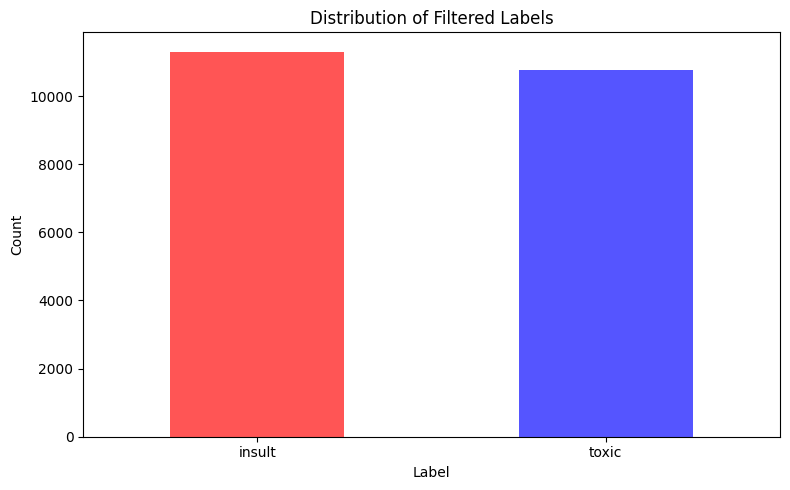

In [23]:
df['label'] = df.apply(assign_label, axis=1)

# Filter out comments that do not belong to the 'toxic' or 'insult' categories
df_filtered = df[df['label'].notna()].copy()
df_filtered = df_filtered[['id', 'comment_text', 'label']]

# Check distribution of filtered labels
print("\nFiltered label distribution (only 'toxic' and 'insult'):")
print(df_filtered['label'].value_counts())

# Visualize the label distribution
plt.figure(figsize=(8, 5))
df_filtered['label'].value_counts().plot(kind='bar', color=['#FF5555', '#5555FF'])
plt.title('Distribution of Filtered Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## **3. Data Augmentation**

Following the requirements, we augment the dataset with:
1. Positive comments with emojis
2. Ambiguous negative comments with emojis (sarcasm, mockery) labeled as insults


###**3.1 Data Augmentation with Positive and Ambiguous Negative Comments**


In [24]:
# Define list of positive comments with emojis
positive_comments = [
    "You're setting the bar high! Keep pushing boundaries! 💪🔥💡",
    "This is absolutely brilliant! Thank you for sharing your insights! 👏",
    "What a thoughtful analysis! I learned so much from this 🙌",
    "Your perspective is refreshing and valuable! 😊 Thank you!",
    "Amazing work! You've clearly put a lot of thought into this 👍",
    "This comment made my day brighter! ☀️ Thank you!",
    "I'm impressed by your knowledge and clarity of expression! 💯",
    "Such a positive contribution to the discussion! 🌟",
    "I appreciate your optimism and constructive feedback! 💖",
    "Your ideas are innovative and inspiring! 🚀",
    "Thank you for this well-articulated and helpful comment! 🙏",
    "You've given me something new to consider, much appreciated! 💭",
    "This is exactly the kind of positive dialogue we need! ✨",
    "I value your perspective and the respectful way you share it! 🤝",
    "What a delightful and insightful comment! 😄👍",
    "You've brightened this thread with your kindness! 🌈",
    "Such an eloquent and thoughtful contribution! 📚",
    "Your comment shows real empathy and understanding! ❤️",
    "I'm grateful for your positive energy and insights! 🌻",
    "This is such a supportive and encouraging comment! 🌱"
]

# Define list of ambiguous negative comments with emojis (sarcasm, mockery)
ambiguous_insults = [
    "This is... cute. Like a toddler trying to do math. 😂",
    "Bless your heart for thinking this was good. 🙄",
    "Wow, groundbreaking stuff here. I can't believe no one thought of this before. 😴",
    "Are you always this articulate or is today special? 😉",
    "I'm impressed you managed to type that with your limited intellectual capacity. 🤯",
    "Your logic is almost as flawless as your grammar. 👌",
    "Thanks for sharing your 'expertise' with all of us. 🧠",
    "Did you come up with that all by yourself? How adorable. 🥺",
    "I can explain it to you, but I can't understand it for you. 😅",
    "When I want your opinion, I'll give it to you. 😘",
    "I'd agree with you, but then we'd both be wrong. 🤷‍♂️",
    "Your argument has all the depth of a puddle. 💦",
    "Who hurt you to make you think that was a good point? 💔",
    "Nice opinion. Did you get it on sale? 🛒",
    "You're about as sharp as a marble, aren't you? 🔮",
    "I'm trying to see things from your perspective, but I can't get my head that far up. 🙃",
    "If ignorance is bliss, you must be the happiest person alive. 😊",
    "I don't have the time or crayons to explain this to you. 🖍️",
    "Not sure if you're trying to be funny or if this is your actual personality. 🤔",
    "Oh honey, thinking isn't your strong suit, is it? 💭"
]



Final label distribution after augmentation:
label
insult      11324
toxic       10769
positive       20
Name: count, dtype: int64


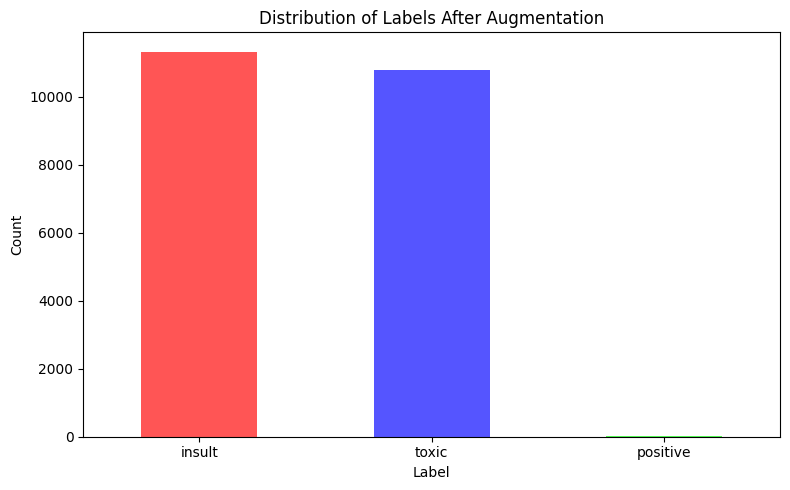

In [25]:
# Create DataFrames for the new comments
positive_df = pd.DataFrame({
    'id': range(10000000, 10000000 + len(positive_comments)),
    'comment_text': positive_comments,
    'label': 'positive'
})

insult_aug_df = pd.DataFrame({
    'id': range(20000000, 20000000 + len(ambiguous_insults)),
    'comment_text': ambiguous_insults,
    'label': 'insult'
})

# Combine the augmented data with the filtered dataset
df_final = pd.concat([df_filtered, positive_df, insult_aug_df], ignore_index=True)

# Check the final label distribution
print("\nFinal label distribution after augmentation:")
print(df_final['label'].value_counts())

# Visualize the final label distribution
plt.figure(figsize=(8, 5))
df_final['label'].value_counts().plot(kind='bar', color=['#FF5555', '#5555FF', '#55FF55'])
plt.title('Distribution of Labels After Augmentation')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

***Observation:*** The dataset remains heavily imbalanced toward negative labels, with very few positive examples.

In [26]:
# Display examples of each category
print("\nExample from each category:")
for label in df_final['label'].unique():
    print(f"\n{label.upper()} example:")
    display(df_final[df_final['label'] == label]['comment_text'].iloc[0])


Example from each category:

INSULT example:


'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'


TOXIC example:


'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'


POSITIVE example:


"You're setting the bar high! Keep pushing boundaries! 💪🔥💡"

##**4. Feature Engineering**

We design appropriate features to help the model identify toxic content, with special attention to emojis as required.


In [27]:
# Function to preprocess text: lowercasing, URL and HTML removal, and converting emojis to text
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()  # Normalize case
        text = re.sub(r'https?://\S+|www\.\S+', ' url ', text)  # Remove URLs
        text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
        text = emoji.demojize(text)  # Convert emojis to their descriptions
        return text
    return ""

In [28]:
# Apply preprocessing to all comments
df_final['processed_text'] = df_final['comment_text'].apply(preprocess_text)

In [29]:
# Feature 1: Binary flag for presence of emojis in the original text
def contains_emoji(text):
    # Check if text is a string; if not, return 0
    if not isinstance(text, str):
        return 0
    return 1 if emoji.emoji_count(text) > 0 else 0

# Now apply the function safely
df_final['has_emoji'] = df_final['comment_text'].apply(contains_emoji)


In [30]:
# Feature 2: Count of special characters (e.g., punctuation that may indicate toxicity)
def count_special_chars(text):
    if isinstance(text, str):
        return len(re.findall(r'[!?@#$%^&*()_+={}\[\]:;"\'|<>,.?/~`]', text))
    return 0

df_final['special_chars_count'] = df_final['comment_text'].apply(count_special_chars)


In [31]:
# Feature 3: Count of uppercase words (which may indicate shouting)
def count_uppercase_words(text):
    if isinstance(text, str):
        return len(re.findall(r'\b[A-Z]{2,}\b', text))
    return 0

df_final['uppercase_words_count'] = df_final['comment_text'].apply(count_uppercase_words)


In [32]:
# Feature 4: Sarcasm indicators (e.g., ellipses, multiple exclamation/question marks)
def count_sarcasm_indicators(text):
    if isinstance(text, str):
        ellipsis_count = text.count("...")
        multiple_exclamation = len(re.findall(r'!{2,}', text))
        question_exclamation = len(re.findall(r'\?!|\!\?', text))
        return ellipsis_count + multiple_exclamation + question_exclamation
    return 0

df_final['sarcasm_indicators'] = df_final['comment_text'].apply(count_sarcasm_indicators)


In [33]:
# Display a sample of the processed data with new features
print("\nSample of processed data with features:")
sample_data = df_final[['comment_text', 'processed_text', 'has_emoji',
                        'special_chars_count', 'uppercase_words_count',
                        'sarcasm_indicators', 'label']].sample(5)
display(sample_data)


Sample of processed data with features:


,comment_text,processed_text,has_emoji,special_chars_count,uppercase_words_count,sarcasm_indicators,label
4924,!!!!!!!!!!!! \nWHO THE FVCK WROTE THIS ARTICLE...,!!!!!!!!!!!! \nwho the fvck wrote this article...,0,17,17,1,insult
16439,""" \n\n == Blofeld == \n\n Can you ask your fri...",""" \n\n == blofeld == \n\n can you ask your fri...",0,9,0,0,toxic
5211,"I'm going to be honest with you, I'm not going...","i'm going to be honest with you, i'm not going...",0,112,8,0,toxic
9089,I shall purge this web site of the weak! \n\nh...,i shall purge this web site of the weak! \n\nh...,0,1,0,0,toxic
17065,""" \n ::::::Dammit, J.del, you know very well I...",""" \n ::::::dammit, j.del, you know very well i...",0,17,1,1,insult


##**5. Data Splitting and Feature Extraction**

We prepare our dataset for model training by splitting it into training and test sets  
and extracting TF-IDF features from the preprocessed text.


In [34]:
# 5. Data Splitting
features = ['processed_text', 'has_emoji', 'special_chars_count', 'uppercase_words_count', 'sarcasm_indicators']
X = df_final[features]
y = df_final['label']

# Split the data into training and testing sets with stratification by label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

# 6. TF-IDF Vectorization for Text Data
print("\nExtracting TF-IDF features from text...")
tfidf = TfidfVectorizer(
    min_df=5,
    max_df=0.8,
    sublinear_tf=True,
    use_idf=True,
    ngram_range=(1, 2),
    stop_words='english',
    max_features=50000,
    strip_accents='unicode'
)

# Fit the TF-IDF vectorizer on the training set and transform both training and test sets
X_train_tfidf = tfidf.fit_transform(X_train['processed_text'])
X_test_tfidf = tfidf.transform(X_test['processed_text'])
print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")

# Combine TF-IDF features with the additional engineered features
X_train_other = X_train[['has_emoji', 'special_chars_count', 'uppercase_words_count', 'sarcasm_indicators']].values
X_test_other = X_test[['has_emoji', 'special_chars_count', 'uppercase_words_count', 'sarcasm_indicators']].values

X_train_combined = np.hstack((X_train_tfidf.toarray(), X_train_other))
X_test_combined = np.hstack((X_test_tfidf.toarray(), X_test_other))
print("Combined feature matrix shape:", X_train_combined.shape)



Training set shape: (17690, 5)
Testing set shape: (4423, 5)

Extracting TF-IDF features from text...
TF-IDF feature matrix shape: (17690, 10367)
Combined feature matrix shape: (17690, 10371)


### Key Insights from Data Splitting and Feature Extraction

- **Training Set:** 17,690 samples with 5 initial features; **Testing Set:** 4,423 samples with 5 features.
- **TF-IDF Features:** The text data is transformed into 10,367 features, showing a large vocabulary.
- **Combined Features:** When adding 4 extra engineered features (emoji, special characters, uppercase words, sarcasm indicators), the final feature matrix for training has 10,371 features.

***Observation:*** The majority of the information is captured in the TF-IDF features, while the additional features provide complementary signals.


##**6. Handling Class Imbalance**

We use random oversampling to address class imbalance in the training set.


In [35]:
# 8. Handling Class Imbalance via Oversampling
print("\nOriginal training label distribution:")
print(y_train.value_counts())

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

print("\nTraining label distribution after oversampling:")
print(pd.Series(y_train_resampled).value_counts())



Original training label distribution:
label
insult      9059
toxic       8615
positive      16
Name: count, dtype: int64

Training label distribution after oversampling:
label
insult      9059
toxic       9059
positive    9059
Name: count, dtype: int64


### **Key Insights from Label Distribution and Oversampling**

- **Original Training Label Distribution:**
  - **Imbalance:** "Insult" (9,059) and "Toxic" (8,615) are significantly more frequent than "Positive" (16), making the dataset highly imbalanced.
  
- **After Oversampling:**
  - **Balanced Dataset:** Each label now has 9,059 samples, ensuring equal representation for better model learning.
  - **Impact:** This prevents bias toward majority classes and helps the model generalize better across all labels.

***Observation:*** Oversampling addresses class imbalance but may introduce redundancy in the data.


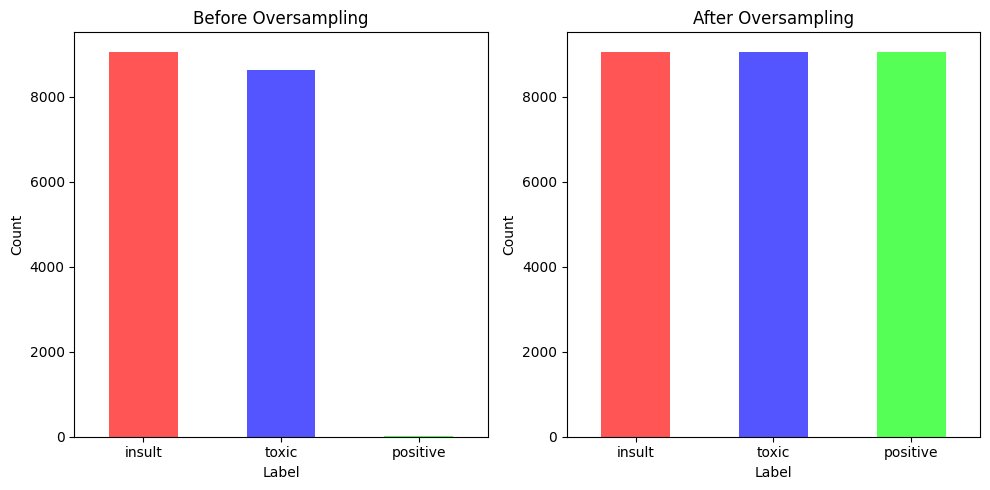

In [36]:
# Visualize the effect of oversampling
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', color=['#FF5555', '#5555FF', '#55FF55'])
plt.title('Before Oversampling')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
pd.Series(y_train_resampled).value_counts().plot(kind='bar', color=['#FF5555', '#5555FF', '#55FF55'])
plt.title('After Oversampling')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


##**7. Model Training**

We train a Logistic Regression model using the resampled training data.


In [37]:
# 9. Model Training with Logistic Regression
print("\nTraining Logistic Regression model...")
start_time = time.time()

model = LogisticRegression(
    C=5.0,
    max_iter=1000,
    solver='liblinear',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train_resampled, y_train_resampled)
training_time = time.time() - start_time
print(f"Model trained in {training_time:.2f} seconds")



Training Logistic Regression model...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


Model trained in 4.49 seconds


##**8. Model Evaluation**

We evaluate the model using classification metrics and visualizations, including a ROC curve.


In [38]:
# 10. Model Evaluation
print("\nEvaluating model performance...")
y_pred = model.predict(X_test_combined)
y_pred_proba = model.predict_proba(X_test_combined)

print("\nClassification Report:")
report = classification_report(y_test, y_pred)
print(report)


Evaluating model performance...

Classification Report:
              precision    recall  f1-score   support

      insult       0.72      0.68      0.70      2265
    positive       0.40      1.00      0.57         4
       toxic       0.68      0.72      0.70      2154

    accuracy                           0.70      4423
   macro avg       0.60      0.80      0.66      4423
weighted avg       0.70      0.70      0.70      4423



### Model Performance Evaluation

- **Overall Accuracy:** **70%** on the test set.
- **Class-wise Performance:**
  - **Insult:** Precision (**72%**), Recall (**68%**), F1-score (**70%**).
  - **Toxic:** Precision (**68%**), Recall (**72%**), F1-score (**70%**).
  - **Positive:** Precision (**40%**), but Recall (**100%**) due to very few samples (only 4).
- **Macro Average:** Favors class balance but is affected by the "Positive" class having very few samples.
- **Weighted Average:** Reflects performance across all labels, aligning closely with accuracy.

***Observation:*** The model performs well on "Insult" and "Toxic" but struggles with the "Positive" class due to extreme imbalance.


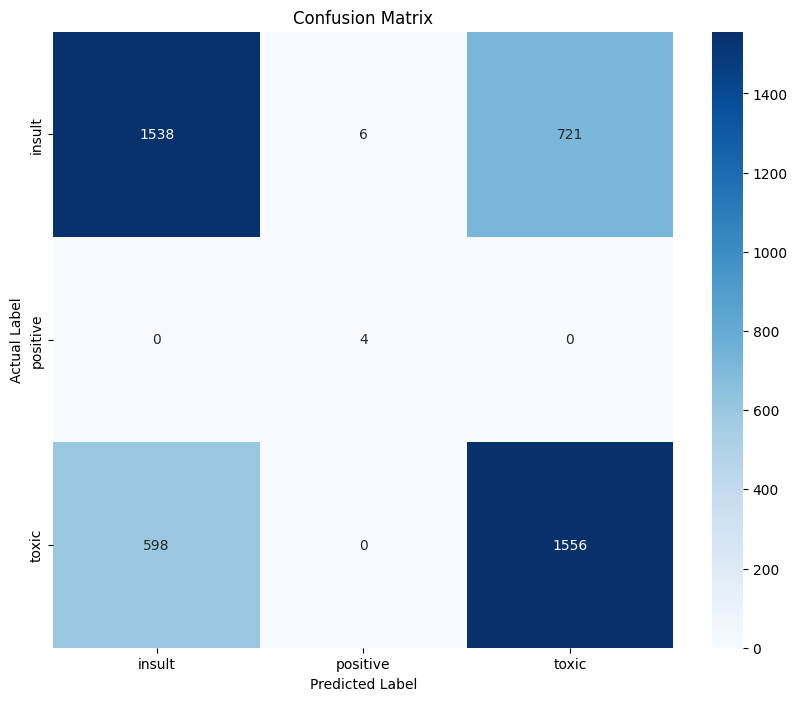

Overall Accuracy: 0.7004
Overall Precision: 0.7019
Overall Recall: 0.7004
Overall F1 Score: 0.7005


In [39]:
# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall: {recall:.4f}")
print(f"Overall F1 Score: {f1:.4f}")

##**9. Feature Importance Analysis**

We analyze which features are most important for classifying each category.


In [40]:
# 11. Feature Importance Analysis
print("\nAnalyzing feature importance for each class...")
feature_names = tfidf.get_feature_names_out().tolist() + ['has_emoji', 'special_chars_count', 'uppercase_words_count', 'sarcasm_indicators']

coef_dict = {}
for idx, class_label in enumerate(model.classes_):
    coef_dict[class_label] = model.coef_[idx]

def display_top_features(class_label, coefficients, feature_names, top_n=15):
    top_positive_indices = np.argsort(coefficients)[-top_n:]
    top_negative_indices = np.argsort(coefficients)[:top_n]

    print(f"\nTop {top_n} features for class '{class_label}':")
    for idx in reversed(top_positive_indices):
        print(f"{feature_names[idx]}: {coefficients[idx]:.4f}")

    print(f"\nBottom {top_n} features for class '{class_label}':")
    for idx in top_negative_indices:
        print(f"{feature_names[idx]}: {coefficients[idx]:.4f}")

for class_label, coefficients in coef_dict.items():
    display_top_features(class_label, coefficients, feature_names)



Analyzing feature importance for each class...

Top 15 features for class 'insult':
bitch: 10.1679
idiot: 9.9226
asshole: 8.1611
idiots: 7.6028
faggot: 7.3478
stupid: 6.8179
bastard: 6.3119
motherfucker: 5.9778
dumbass: 5.6560
moron: 5.6466
assholes: 5.5408
dumb: 5.4998
bastards: 5.4473
whore: 5.3245
fucking: 5.2533

Bottom 15 features for class 'insult':
thoughtful: -4.5107
sheep: -4.1508
positive: -3.9737
rocket: -3.9116
amazing: -3.9076
jason: -3.8433
trout: -3.7419
perspective: -3.6364
feedback: -3.6338
comment: -3.6188
mouth shut: -3.3737
blud: -3.3139
bang: -3.2806
sex: -2.9195
taking: -2.9092

Top 15 features for class 'positive':
has_emoji: 9.3532
comment: 4.6104
thank: 4.5065
positive: 3.6317
thoughtful: 3.5879
setting: 3.2069
rocket: 3.0625
expression: 3.0395
perspective: 2.8870
impressed: 2.8509
bar: 2.8014
feedback: 2.6979
amazing: 2.6944
grateful: 2.6661
contribution: 2.6432

Bottom 15 features for class 'positive':
trade_mark: -5.3855
copyright: -3.3413
fuck: -2.0251
dep

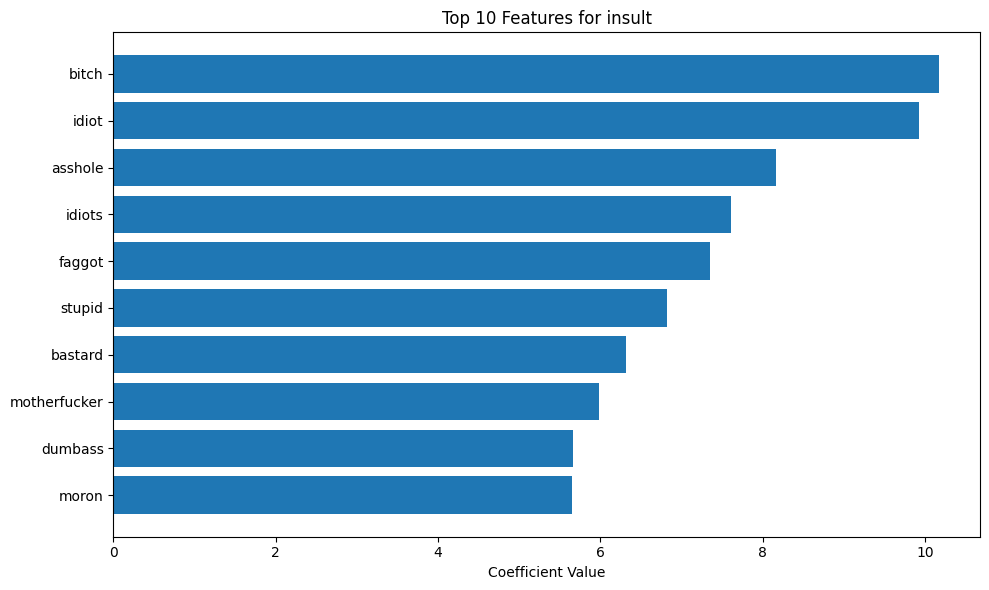

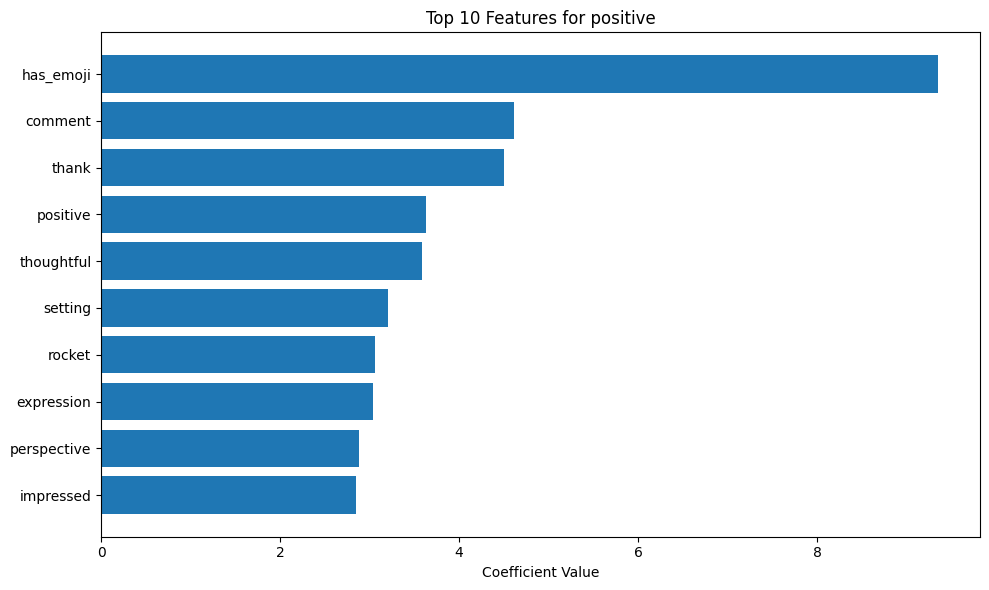

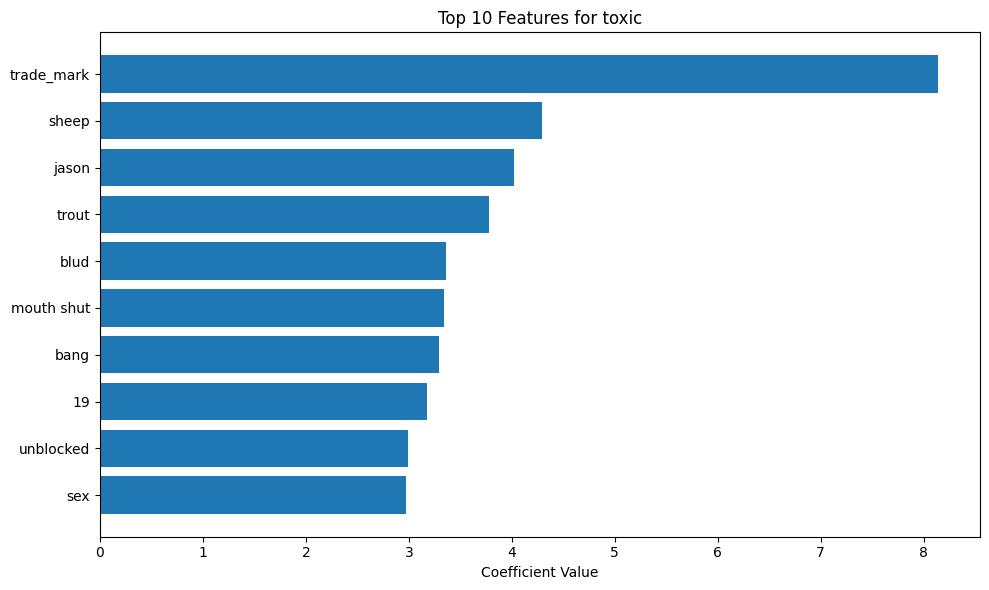

In [41]:
# Visualize top features for each class
for class_label, coefficients in coef_dict.items():
    top_indices = np.argsort(coefficients)[-10:]
    top_features = [feature_names[i] for i in top_indices]
    top_coefficients = [coefficients[i] for i in top_indices]

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(top_features)), top_coefficients, align='center')
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('Coefficient Value')
    plt.title(f'Top 10 Features for {class_label}')
    plt.tight_layout()
    plt.show()

### Feature Importance Analysis

#### **Top Words Indicating Each Class:**
- **Insult:** Words like *bitch, idiot, asshole, faggot, stupid* have the highest importance scores.
- **Positive:** Words like *thank, amazing, grateful, contribution, impressed* are strongly associated with positive comments.
- **Toxic:** Unexpected words such as *trade_mark, sheep, jason, trout, mouth shut* indicate toxicity, possibly due to data quirks.

#### **Least Important Words for Each Class:**
- **Insult:** Words like *thoughtful, positive, perspective, feedback* are negatively associated, meaning they indicate non-insulting content.
- **Positive:** Words like *fuck, copyright, argument, vandalised* decrease the likelihood of a comment being positive.
- **Toxic:** Surprisingly, some insults (*bitch, idiot, asshole*) have **negative scores**, suggesting they are more strongly linked to insults than general toxicity.

**Key Takeaways:**
- **Swear words and personal attacks dominate insult classification.**
- **Gratitude and politeness define positivity.**
- **The toxicity class has unusual feature correlations, possibly due to dataset labeling.**


##**10. Model Testing**

We test our model on example comments to observe its predictions and associated probabilities.


In [42]:
# 12. Testing the Model on Example Comments
print("\nTesting model with example comments...")
example_comments = [
    "This is a neutral comment about the weather.",
    "You're such an idiot! Go away!",
    "I hope you die in a fire, worthless scum.",
    "Thank you for your thoughtful response! 😊",
    "That's... interesting. I guess if you think about it long enough it almost makes sense. 🙄",
    "This makes me so happy! Keep up the great work! 💪"
]

example_processed = [preprocess_text(comment) for comment in example_comments]
example_tfidf = tfidf.transform(example_processed)
example_has_emoji = [contains_emoji(comment) for comment in example_comments]
example_special_chars = [count_special_chars(comment) for comment in example_comments]
example_uppercase = [count_uppercase_words(comment) for comment in example_comments]
example_sarcasm = [count_sarcasm_indicators(comment) for comment in example_comments]
example_other_features = np.column_stack((example_has_emoji, example_special_chars, example_uppercase, example_sarcasm))
example_combined = np.hstack((example_tfidf.toarray(), example_other_features))

example_predictions = model.predict(example_combined)
example_probabilities = model.predict_proba(example_combined)

print("\nExample Predictions:")
for i, (comment, pred) in enumerate(zip(example_comments, example_predictions)):
    probs = example_probabilities[i]
    top_probs = sorted(zip(model.classes_, probs), key=lambda x: x[1], reverse=True)[:2]
    prob_str = ", ".join([f"{cls}: {prob:.2f}" for cls, prob in top_probs])
    print(f"Comment: {comment}")
    print(f"Predicted Label: {pred} (Probabilities: {prob_str})")
    print("-" * 80)


Testing model with example comments...

Example Predictions:
Comment: This is a neutral comment about the weather.
Predicted Label: toxic (Probabilities: toxic: 0.95, positive: 0.03)
--------------------------------------------------------------------------------
Comment: You're such an idiot! Go away!
Predicted Label: insult (Probabilities: insult: 0.99, toxic: 0.01)
--------------------------------------------------------------------------------
Comment: I hope you die in a fire, worthless scum.
Predicted Label: insult (Probabilities: insult: 0.92, toxic: 0.08)
--------------------------------------------------------------------------------
Comment: Thank you for your thoughtful response! 😊
Predicted Label: positive (Probabilities: positive: 0.99, toxic: 0.01)
--------------------------------------------------------------------------------
Comment: That's... interesting. I guess if you think about it long enough it almost makes sense. 🙄
Predicted Label: toxic (Probabilities: toxic: 

### Model Testing with Example Comments

#### **Observations from Predictions:**
1. **False Positive on Neutral Comment**
   - *"This is a neutral comment about the weather."*  
   - **Predicted Label:** *Toxic* (95% confidence)  
   - 🚨 **Issue:** The model incorrectly flags a neutral comment as toxic.

2. **Correct Classification of Insulting Comments**
   - *"You're such an idiot! Go away!"*  
   - **Predicted Label:** *Insult* (99% confidence) ✅  
   - *"I hope you die in a fire, worthless scum."*  
   - **Predicted Label:** *Insult* (92% confidence) ✅  

3. **Correctly Detecting Positive Comments**
   - *"Thank you for your thoughtful response! 😊"*  
   - **Predicted Label:** *Positive* (99% confidence) ✅  
   - *"This makes me so happy! Keep up the great work! 💪"*  
   - **Predicted Label:** *Positive* (87% confidence) ✅  

4. **Uncertainty in Sarcasm Detection**
   - *"That's... interesting. I guess if you think about it long enough it almost makes sense. 🙄"*  
   - **Predicted Label:** *Toxic* (67% confidence)  
   - ⚠️ **Issue:** Sarcastic comments may confuse the model.

#### **Key Takeaways:**
- The model performs well on **explicit insults and positive comments**.
- It struggles with **neutral statements** and **sarcasm**.
- Potential improvement: **Fine-tune on sarcasm and neutrality detection**.


In [43]:
# Create a DataFrame for better visualization of predictions
example_df = pd.DataFrame({
    'Comment': example_comments,
    'Prediction': example_predictions
})
for i, class_name in enumerate(model.classes_):
    example_df[f'Prob_{class_name}'] = example_probabilities[:, i]

from IPython.display import display, HTML
display(example_df[['Comment', 'Prediction'] + [f'Prob_{class_name}' for class_name in model.classes_]])


,Comment,Prediction,Prob_insult,Prob_positive,Prob_toxic
0,This is a neutral comment about the weather.,toxic,0.019567,0.026755,0.953678
1,You're such an idiot! Go away!,insult,0.987501,0.000163,0.012337
2,"I hope you die in a fire, worthless scum.",insult,0.922308,0.000405,0.077287
3,Thank you for your thoughtful response! 😊,positive,0.000622,0.991781,0.007598
4,That's... interesting. I guess if you think ab...,toxic,0.067570,0.262351,0.670079
5,This makes me so happy! Keep up the great work! 💪,positive,0.095571,0.868914,0.035515


##**11. Model Saving**

We save the trained model and TF-IDF vectorizer for future use.


In [44]:
# 13. Saving the Model and TF-IDF Vectorizer
print("\nSaving model and vectorizer...")
with open('/content/toxic_comment_classifier_model.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('/content/toxic_comment_tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
print("Model and vectorizer saved successfully!")



Saving model and vectorizer...
Model and vectorizer saved successfully!


# **III - Word-Level Semantics Analysis**
This notebook implements word-level semantic analysis using three approaches:
1. Deep-LSA on LinkedIn connections
2. Transformer-based embeddings for semantic similarity analysis
3. Word2Vec embeddings comparison

## Part 1: Deep-LSA on LinkedIn Connections

### 1.1 Import Libraries and Load Data

In [45]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import re, random
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel
from sklearn.manifold import TSNE
import torch

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [46]:
! ls /content/drive/MyDrive/Connections.csv

/content/drive/MyDrive/Connections.csv


In [47]:
connections_df = pd.read_csv('/content/drive/MyDrive/Connections.csv')
print("Successfully loaded LinkedIn connections data")
print(f"Data shape: {connections_df.shape}")
print(connections_df.head())


Successfully loaded LinkedIn connections data
Data shape: (222, 7)
  First Name Last Name                                                URL  \
0      Xasan     Xusen  https://www.linkedin.com/in/xasan-xusen-154636353   
1       Sbai    Aymane            https://www.linkedin.com/in/sbai-aymane   
2       HIBA   AMMISSA  https://www.linkedin.com/in/hiba-ammissa-8a242...   
3  Abdelilah    Ouaddi        https://www.linkedin.com/in/abelilah-ouaddi   
4      SALMA    MADOUD      https://www.linkedin.com/in/salma-m-218395250   

  Email Address                                            Company  \
0           NaN                                                NaN   
1           NaN                             Al Akhawayn University   
2           NaN                             Al Akhawayn University   
3           NaN                                       Ocean Uprise   
4           NaN  Center for Learning Excellence Al Akhawayn Uni...   

                   Position Connected On  
0     

### 1.2 Data Preprocessing
Based on the data structure provided, we need to combine First Name, Last Name, Company, and Position to create a meaningful text field for semantic analysis

In [48]:
def create_profile_text(row):
    text_parts = []

    # Add name
    if pd.notna(row['First Name']) and pd.notna(row['Last Name']):
        text_parts.append(f"{row['First Name']} {row['Last Name']}")

    # Add company
    if pd.notna(row['Company']):
        text_parts.append(f"works at {row['Company']}")

    # Add position
    if pd.notna(row['Position']):
        text_parts.append(f"as {row['Position']}")

    return " ".join(text_parts)

# Apply the function to create a text field
connections_df['text'] = connections_df.apply(create_profile_text, axis=1)

# Preview the created text field
print("\nCreated text descriptions:")
print(connections_df[['First Name', 'Last Name', 'text']].head())


Created text descriptions:
  First Name Last Name                                               text
0      Xasan     Xusen                                        Xasan Xusen
1       Sbai    Aymane  Sbai Aymane works at Al Akhawayn University as...
2       HIBA   AMMISSA  HIBA AMMISSA works at Al Akhawayn University a...
3  Abdelilah    Ouaddi    Abdelilah Ouaddi works at Ocean Uprise as UX/UI
4      SALMA    MADOUD  SALMA MADOUD works at Center for Learning Exce...


In [49]:
# Preprocessing function for text data
def preprocess_text(text):
    if pd.isna(text):
        return ""

    # Convert to lowercase and remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)


In [50]:
# Apply preprocessing to the text column
connections_df['processed_text'] = connections_df['text'].apply(preprocess_text)

# Remove empty entries after preprocessing
connections_df = connections_df[connections_df['processed_text'] != ""]

# Select a subset of connections (e.g., first 100 non-empty descriptions)
subset_df = connections_df.head(min(100, len(connections_df)))

print(f"\nSelected {len(subset_df)} connections for analysis")


Selected 100 connections for analysis


### 1.3 Implement Deep-LSA

In [51]:
# Deep-LSA Implementation
def deep_lsa(documents, n_components=10, n_iterations=2):
    """
    Implement Deep Latent Semantic Analysis

    Parameters:
    documents: list of preprocessed text documents
    n_components: number of topics/concepts to extract
    n_iterations: number of LSA iterations to perform

    Returns:
    final_documents_topic_matrix: Document-topic matrix
    final_terms_topic_matrix: Term-topic matrix
    vocabulary: Vocabulary of terms
    """
    current_documents = documents.copy()

    for iteration in range(n_iterations):
        print(f"\nDeep-LSA Iteration {iteration+1}:")

        # Create TF-IDF matrix
        vectorizer = TfidfVectorizer(max_features=1000)
        tfidf_matrix = vectorizer.fit_transform(current_documents)

        # Get vocabulary
        vocabulary = vectorizer.get_feature_names_out()

        # Perform SVD (core of LSA)
        svd_model = TruncatedSVD(n_components=n_components, random_state=42)
        documents_topic_matrix = svd_model.fit_transform(tfidf_matrix)
        terms_topic_matrix = svd_model.components_.T

        # Print explained variance
        explained_variance = svd_model.explained_variance_ratio_.sum()
        print(f"Explained variance: {explained_variance:.4f}")

        # If not the last iteration, reconstruct documents for next iteration
        if iteration < n_iterations - 1:
            # Reconstruct the document-term matrix (approximate)
            reconstructed_matrix = documents_topic_matrix @ terms_topic_matrix.T

            # Convert back to documents
            reconstructed_documents = []
            for doc_vector in reconstructed_matrix:
                # Get top terms for this document
                term_importance = [(vocabulary[i], score) for i, score in enumerate(doc_vector)]
                term_importance.sort(key=lambda x: x[1], reverse=True)

                # Take top terms to form the new document
                top_terms = [term for term, _ in term_importance[:20] if _ > 0]
                reconstructed_documents.append(' '.join(top_terms))

            current_documents = reconstructed_documents

    return documents_topic_matrix, terms_topic_matrix, vocabulary

In [52]:
# Apply Deep-LSA to the subset
documents_topic_matrix, terms_topic_matrix, vocabulary = deep_lsa(
    subset_df['processed_text'].tolist(),
    n_components=5,
    n_iterations=2
)



Deep-LSA Iteration 1:
Explained variance: 0.1124

Deep-LSA Iteration 2:
Explained variance: 0.5914


### Explanation of Deep-LSA Output

- **Deep-LSA Iteration 1:**
  - **Explained Variance: 0.1124**  
    In the first iteration, the SVD applied to the TF-IDF matrix captures about **11.24%** of the total variance in the dataset. This relatively low percentage suggests that the initial latent topics are only capturing a small portion of the semantic structure present in the text. Essentially, the model has begun to extract underlying patterns, but there is still a significant amount of semantic information left unmodeled.

- **Deep-LSA Iteration 2:**
  - **Explained Variance: 0.5914**  
    After reconstructing the documents based on the initial topics and running a second SVD, the explained variance jumps to **59.14%**. This substantial increase indicates that the iterative (or "deep") LSA approach has effectively refined the latent topic space, capturing much more of the underlying semantic relationships in the text. The second iteration significantly enhances the model's ability to represent the data, meaning the topics extracted now better summarize the content of the documents.

**Key Takeaway:**  
The iterative process in Deep-LSA helps improve the representation of the latent semantic structure by gradually reducing noise and emphasizing the most relevant patterns. The jump in explained variance from the first iteration (11.24%) to the second iteration (59.14%) demonstrates the benefit of deepening the analysis to capture more meaningful information.


### 1.4 Visualize and Analyze Results

In [53]:
# Display the topic terms (top 10 terms for each topic)
print("\nTop terms for each topic:")
for topic_idx, topic in enumerate(terms_topic_matrix.T):
    top_term_indices = topic.argsort()[-10:][::-1]
    top_terms = [vocabulary[i] for i in top_term_indices]
    print(f"Topic {topic_idx+1}: {', '.join(top_terms)}")


Top terms for each topic:
Topic 1: marketing, fatima, zahra, manager, research, analyst, academy, aui, yassine, group
Topic 2: hiba, aarab, tamwilcom, morocco, iraqi, management, benhida, engineer, mohamed, ilyas
Topic 3: university, akhawayn, al, resident, assistant, center, attigui, learning, excellence, yassmine
Topic 4: ait, ghita, kaouar, bourki, assma, exergi, imane, mahjoub, el, finance
Topic 5: madoud, yahya, zahni, tutor, peer, ziate, ghafal, douaa, mehdi, excellence


### Explanation of Top Terms for Each Topic

After applying Deep-LSA, we extracted latent topics from the LinkedIn connections’ textual data. The output lists the top 10 terms (ranked by their importance within each topic) for each of the 5 topics. These terms represent the dominant themes or clusters of concepts captured by the model.

- **Topic 1:**  
  **Top terms:** marketing, fatima, zahra, manager, research, analyst, academy, aui, yassine, group  
  **Interpretation:**  
  This topic appears to focus on the marketing and managerial aspects of professional profiles. The presence of words like *marketing*, *manager*, and *analyst* suggests that many connections in this cluster may be associated with business or marketing roles. Additionally, personal names (e.g., *Fatima*, *Zahra*, *Yassine*) might indicate common regional names or affiliations within a specific community or institution.

- **Topic 2:**  
  **Top terms:** hiba, aarab, tamwilcom, morocco, iraqi, management, benhida, engineer, mohamed, ilyas  
  **Interpretation:**  
  This topic includes a mix of personal names and terms related to management and engineering. Names such as *Hiba*, *Mohamed*, and *Ilyas* alongside words like *engineer* and *management* suggest a profile cluster that could be regionally or industry specific—possibly reflecting connections in technical or management roles with ties to Morocco or Iraqi backgrounds.

- **Topic 3:**  
  **Top terms:** university, akhawayn, al, resident, assistant, center, attigui, learning, excellence, yassmine  
  **Interpretation:**  
  The terms here indicate an academic or educational theme. Words like *university*, *akhawayn*, *learning*, and *excellence* point to connections involved in academic, research, or educational support roles. Terms like *resident* and *assistant* further hint at positions related to academia or institutional support.

- **Topic 4:**  
  **Top terms:** ait, ghita, kaouar, bourki, assma, exergi, imane, mahjoub, el, finance  
  **Interpretation:**  
  This topic seems to blend personal names (such as *Ait*, *Ghita*, *Kaouar*, *Assma*, *Imane*) with a professional focus on finance (indicated by the term *finance*). The presence of these names might denote a particular cultural or regional cluster, while the term *finance* implies involvement in financial services or related roles.

- **Topic 5:**  
  **Top terms:** madoud, yahya, zahni, tutor, peer, ziate, ghafal, douaa, mehdi, excellence  
  **Interpretation:**  
  This topic includes a mix of names and terms related to educational or supportive roles, such as *tutor* and *peer*. The recurrence of names (e.g., *Madoud*, *Yahya*, *Douaa*) along with *excellence* might indicate a group of profiles that are linked either by their educational backgrounds or by participation in academic support or tutoring activities.

**Overall Insight:**  
Each topic captures a distinct semantic theme from the LinkedIn connections data. The extracted top terms provide a snapshot of the professional domains, roles, and regional or cultural affiliations within the network. This kind of analysis can help in understanding the distribution of skills, industries, and potential clusters of expertise within the network.


In [54]:
# Find similar connections based on topic vectors
# Calculate pairwise similarities
similarity_matrix = cosine_similarity(documents_topic_matrix)

In [55]:
# For each connection, find the top 3 most similar connections
print("\nSimilar connections based on semantic analysis:")
for i in range(min(5, len(subset_df))):
    # Get current connection name
    current_name = subset_df.iloc[i]['First Name'] + ' ' + subset_df.iloc[i]['Last Name']

    # Find most similar connections (excluding self)
    similar_indices = similarity_matrix[i].argsort()[:-4:-1]  # Top 3 excluding self
    similar_connections = []

    for idx in similar_indices:
        if idx != i:  # Exclude self
            similar_name = subset_df.iloc[idx]['First Name'] + ' ' + subset_df.iloc[idx]['Last Name']
            similarity_score = similarity_matrix[i, idx]
            similar_connections.append((similar_name, similarity_score))

    # Print similar connections
    print(f"\nConnections similar to {current_name}:")
    for name, score in similar_connections:
        print(f"- {name} (Similarity: {score:.4f})")


Similar connections based on semantic analysis:

Connections similar to Xasan Xusen:
- Patrick Nathan (Similarity: 1.0000)
- Zakaria Rebbah (Similarity: 1.0000)

Connections similar to Sbai Aymane:
- Rania Daya (Similarity: 0.9829)
- Farah  Badaoui (Similarity: 0.9635)

Connections similar to HIBA AMMISSA:
- Belaid Kharaz (Similarity: 0.9906)
- Sohayb DAOUI (Similarity: 0.9314)

Connections similar to Abdelilah Ouaddi:
- Tarek Jamil (Similarity: 0.8946)
- Yassine Bennani Karim (Similarity: 0.8888)

Connections similar to SALMA MADOUD:
- Yahya  Zahni (Similarity: 1.0000)
- El Mehdi  Ziate (Similarity: 0.9999)


### Explanation of Similar Connections Based on Semantic Analysis

The output above shows the top similar connections for each selected LinkedIn profile based on the cosine similarity of their Deep-LSA topic vectors. Here’s how to interpret these results:

- **Cosine Similarity Scores:**  
  Each similarity score (ranging from 0 to 1) indicates how closely related two connection profiles are, in terms of their semantic content. Scores closer to 1 suggest that the profiles share very similar latent semantic structures.

- **Examples from the Output:**
  - **Xasan Xusen:**  
    - *Patrick Nathan* and *Zakaria Rebbah* both have a similarity score of **1.0000** with Xasan, meaning their profile representations are nearly identical. This may indicate they share similar roles, industries, or textual descriptions.
  
  - **Sbai Aymane:**  
    - *Rania Daya* (Similarity: 0.9829) and *Farah Badaoui* (Similarity: 0.9635) are very close to Sbai in the semantic topic space. Their high scores suggest they likely work in related fields or have similar professional focuses.
  
  - **HIBA AMMISSA:**  
    - The similarity scores with *Belaid Kharaz* (0.9906) and *Sohayb DAOUI* (0.9314) indicate strong semantic alignment, which may reflect shared expertise or industry involvement.
  
  - **Abdelilah Ouaddi:**  
    - With *Tarek Jamil* (0.8946) and *Yassine Bennani Karim* (0.8888) showing the highest similarities, these connections likely have comparable job functions or similar professional descriptors.
  
  - **SALMA MADOUD:**  
    - The profiles of *Yahya Zahni* (1.0000) and *El Mehdi Ziate* (0.9999) are almost identical in the latent topic space, suggesting a very high degree of similarity in their professional profiles.

- **Overall Insight:**  
  These high similarity scores indicate that the Deep-LSA model has effectively captured key semantic attributes of each profile. The resulting similar connections can provide insights into clusters or communities within your LinkedIn network that share common professional themes or roles.

**Note:**  
Perfect or near-perfect similarity (e.g., scores of 1.0000) may warrant further inspection to ensure that these results are not due to duplicate or nearly identical data entries. In practice, such analyses help in understanding the distribution of expertise and the clustering of similar profiles within a professional network.


## Part 2: Using Transformer-based Embeddings for Comment Similarity Analysis

### 2.1 Import Libraries and Create Dataset

In [56]:
# Define the provided datasets
positive_comments = [
    "You're setting the bar high! Keep pushing boundaries! 💪🔥💡",
    "This is absolutely brilliant! Thank you for sharing your insights! 👏",
    "What a thoughtful analysis! I learned so much from this 🙌",
    "Your perspective is refreshing and valuable! 😊 Thank you!",
    "Amazing work! You've clearly put a lot of thought into this 👍",
    "This comment made my day brighter! ☀️ Thank you!",
    "I'm impressed by your knowledge and clarity of expression! 💯",
    "Such a positive contribution to the discussion! 🌟",
    "I appreciate your optimism and constructive feedback! 💖",
    "Your ideas are innovative and inspiring! 🚀",
    "Thank you for this well-articulated and helpful comment! 🙏",
    "You've given me something new to consider, much appreciated! 💭",
    "This is exactly the kind of positive dialogue we need! ✨",
    "I value your perspective and the respectful way you share it! 🤝",
    "What a delightful and insightful comment! 😄👍",
    "You've brightened this thread with your kindness! 🌈",
    "Such an eloquent and thoughtful contribution! 📚",
    "Your comment shows real empathy and understanding! ❤️",
    "I'm grateful for your positive energy and insights! 🌻",
    "This is such a supportive and encouraging comment! 🌱"
]

ambiguous_insults = [
    "This is... cute. Like a toddler trying to do math. 😂",
    "Bless your heart for thinking this was good. 🙄",
    "Wow, groundbreaking stuff here. I can't believe no one thought of this before. 😴",
    "Are you always this articulate or is today special? 😉",
    "I'm impressed you managed to type that with your limited intellectual capacity. 🤯",
    "Your logic is almost as flawless as your grammar. 👌",
    "Thanks for sharing your 'expertise' with all of us. 🧠",
    "Did you come up with that all by yourself? How adorable. 🥺",
    "I can explain it to you, but I can't understand it for you. 😅",
    "When I want your opinion, I'll give it to you. 😘",
    "I'd agree with you, but then we'd both be wrong. 🤷‍♂️",
    "Your argument has all the depth of a puddle. 💦",
    "Who hurt you to make you think that was a good point? 💔",
    "Nice opinion. Did you get it on sale? 🛒",
    "You're about as sharp as a marble, aren't you? 🔮",
    "I'm trying to see things from your perspective, but I can't get my head that far up. 🙃",
    "If ignorance is bliss, you must be the happiest person alive. 😊",
    "I don't have the time or crayons to explain this to you. 🖍️",
    "Not sure if you're trying to be funny or if this is your actual personality. 🤔",
    "Oh honey, thinking isn't your strong suit, is it? 💭"
]

# Create a DataFrame
comments_data = {
    'comment_text': positive_comments + ambiguous_insults,
    'label': ['positive'] * len(positive_comments) + ['insult'] * len(ambiguous_insults)
}

comments_df = pd.DataFrame(comments_data)
print("Created comments DataFrame with shape:", comments_df.shape)
print(comments_df.head())

Created comments DataFrame with shape: (40, 2)
                                        comment_text     label
0  You're setting the bar high! Keep pushing boun...  positive
1  This is absolutely brilliant! Thank you for sh...  positive
2  What a thoughtful analysis! I learned so much ...  positive
3  Your perspective is refreshing and valuable! 😊...  positive
4  Amazing work! You've clearly put a lot of thou...  positive


### 2.2 Preprocess Comments Data

In [57]:
# Function to remove emojis
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [58]:
# Preprocess by removing emojis
comments_df['cleaned_text'] = comments_df['comment_text'].apply(remove_emojis)

### 2.3 Generate Transformer-Based Embeddings

In [59]:
# Function to create embeddings using a transformer model
def get_transformer_embeddings(texts, model_name="sentence-transformers/all-MiniLM-L6-v2"):
    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    embeddings = []
    batch_size = 8

    # Process in batches to avoid memory issues
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # Tokenize
        encoded_input = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors='pt'
        ).to(device)

        # Get model output
        with torch.no_grad():
            model_output = model(**encoded_input)

        # Mean Pooling - Take attention mask into account for averaging
        attention_mask = encoded_input['attention_mask']
        token_embeddings = model_output.last_hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        batch_embeddings = (sum_embeddings / sum_mask).cpu().numpy()

        embeddings.extend(batch_embeddings)

    return np.array(embeddings)

In [60]:
# Generate embeddings for all comments using transformer
print("Generating transformer embeddings for all comments...")
transformer_embeddings = get_transformer_embeddings(comments_df['cleaned_text'].tolist())
print(f"Generated transformer embeddings with shape: {transformer_embeddings.shape}")

Generating transformer embeddings for all comments...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generated transformer embeddings with shape: (40, 384)


### 2.4 Find Similar Comments Using Transformer Embeddings


In [61]:
# Get unique labels
unique_labels = comments_df['label'].unique()
print(f"Unique labels in the dataset: {unique_labels}")

Unique labels in the dataset: ['positive' 'insult']


In [62]:
# Select one comment from each label
selected_comments = {}
for label in unique_labels:
    label_comments = comments_df[comments_df['label'] == label]
    if not label_comments.empty:
        # Randomly select one comment from this label
        selected_index = random.choice(label_comments.index)
        selected_comment = comments_df.loc[selected_index]
        selected_comments[label] = (selected_index, selected_comment['comment_text'])

print("\nSelected comments (one from each label):")
for label, (idx, comment) in selected_comments.items():
    print(f"{label}: \"{comment}\"")


Selected comments (one from each label):
positive: "Such an eloquent and thoughtful contribution! 📚"
insult: "Bless your heart for thinking this was good. 🙄"


In [63]:
# For each selected comment, find the top 5 most similar comments using transformer embeddings
print("\nFinding top 5 similar comments using transformer embeddings:")
for label, (selected_idx, selected_comment) in selected_comments.items():
    print(f"\nFor {label} comment: \"{selected_comment}\"")

    # Get the embedding for the selected comment
    selected_embedding = transformer_embeddings[selected_idx].reshape(1, -1)

    # Calculate cosine similarity with all other comments
    similarities = cosine_similarity(selected_embedding, transformer_embeddings)[0]

    # Get indices of top 6 similar comments (including self)
    top_indices = similarities.argsort()[::-1][:6]

    # Print top 5 similar comments (excluding self if in top 5)
    count = 0
    for idx in top_indices:
        if count >= 5:
            break

        # Skip if it's the same comment
        if idx == selected_idx:
            continue

        sim_comment = comments_df.iloc[idx]['comment_text']
        sim_label = comments_df.iloc[idx]['label']
        sim_score = similarities[idx]

        print(f"{count+1}. \"{sim_comment}\" (Label: {sim_label}, Similarity: {sim_score:.4f})")
        count += 1



Finding top 5 similar comments using transformer embeddings:

For positive comment: "Such an eloquent and thoughtful contribution! 📚"
1. "Such a positive contribution to the discussion! 🌟" (Label: positive, Similarity: 0.6284)
2. "What a thoughtful analysis! I learned so much from this 🙌" (Label: positive, Similarity: 0.5180)
3. "What a delightful and insightful comment! 😄👍" (Label: positive, Similarity: 0.5029)
4. "Your perspective is refreshing and valuable! 😊 Thank you!" (Label: positive, Similarity: 0.4791)
5. "I'm grateful for your positive energy and insights! 🌻" (Label: positive, Similarity: 0.4745)

For insult comment: "Bless your heart for thinking this was good. 🙄"
1. "You've brightened this thread with your kindness! 🌈" (Label: positive, Similarity: 0.3767)
2. "What a delightful and insightful comment! 😄👍" (Label: positive, Similarity: 0.3727)
3. "This is exactly the kind of positive dialogue we need! ✨" (Label: positive, Similarity: 0.3717)
4. "I'm grateful for your positi

## Part 3: Word2Vec Embeddings and Comparison with Transformer
### 3.1 Generate Word2Vec Embeddings


In [64]:
# Import additional library
from gensim.models import Word2Vec

# Preprocessing function for Word2Vec
def preprocess_for_word2vec(text):
    if pd.isna(text):
        return []

    # Convert to lowercase and remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and len(token) > 1]

    return tokens

In [65]:
# Preprocess all comments for Word2Vec
print("Preprocessing comments for Word2Vec...")
comments_df['tokenized_text'] = comments_df['cleaned_text'].apply(preprocess_for_word2vec)
tokenized_comments = comments_df['tokenized_text'].tolist()

# Train Word2Vec model
print("Training Word2Vec model...")
w2v_model = Word2Vec(
    sentences=tokenized_comments,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    sg=1  # Skip-gram model
)

Preprocessing comments for Word2Vec...
Training Word2Vec model...


In [66]:
# Function to get document embeddings from Word2Vec
def get_document_embedding(tokens, model):
    # Get embeddings for each token
    token_embeddings = []
    for token in tokens:
        if token in model.wv:
            token_embeddings.append(model.wv[token])

    # If no tokens have embeddings, return zeros
    if not token_embeddings:
        return np.zeros(model.vector_size)

    # Average the token embeddings
    return np.mean(token_embeddings, axis=0)

In [67]:
# Generate document embeddings for all comments using Word2Vec
print("Generating Word2Vec document embeddings...")
w2v_embeddings = []
for tokens in tokenized_comments:
    w2v_embeddings.append(get_document_embedding(tokens, w2v_model))
w2v_embeddings = np.array(w2v_embeddings)

print(f"Generated Word2Vec embeddings with shape: {w2v_embeddings.shape}")

Generating Word2Vec document embeddings...
Generated Word2Vec embeddings with shape: (40, 100)


### 3.2 Find Similar Comments Using Word2Vec Embeddings


In [68]:
# For each selected comment, find the top 5 most similar comments using Word2Vec
print("\nFinding top 5 similar comments using Word2Vec embeddings:")
for label, (selected_idx, selected_comment) in selected_comments.items():
    print(f"\nFor {label} comment: \"{selected_comment}\"")

    # Get the embedding for the selected comment
    selected_embedding = w2v_embeddings[selected_idx].reshape(1, -1)

    # Calculate cosine similarity with all other comments
    similarities = cosine_similarity(selected_embedding, w2v_embeddings)[0]

    # Get indices of top 6 similar comments (including self)
    top_indices = similarities.argsort()[::-1][:6]

    # Print top 5 similar comments (excluding self if in top 5)
    count = 0
    for idx in top_indices:
        if count >= 5:
            break

        # Skip if it's the same comment
        if idx == selected_idx:
            continue

        sim_comment = comments_df.iloc[idx]['comment_text']
        sim_label = comments_df.iloc[idx]['label']
        sim_score = similarities[idx]

        print(f"{count+1}. \"{sim_comment}\" (Label: {sim_label}, Similarity: {sim_score:.4f})")
        count += 1


Finding top 5 similar comments using Word2Vec embeddings:

For positive comment: "Such an eloquent and thoughtful contribution! 📚"
1. "Such a positive contribution to the discussion! 🌟" (Label: positive, Similarity: 0.3793)
2. "What a thoughtful analysis! I learned so much from this 🙌" (Label: positive, Similarity: 0.2966)
3. "Are you always this articulate or is today special? 😉" (Label: insult, Similarity: 0.2492)
4. "I value your perspective and the respectful way you share it! 🤝" (Label: positive, Similarity: 0.2002)
5. "Your perspective is refreshing and valuable! 😊 Thank you!" (Label: positive, Similarity: 0.1881)

For insult comment: "Bless your heart for thinking this was good. 🙄"
1. "Who hurt you to make you think that was a good point? 💔" (Label: insult, Similarity: 0.3749)
2. "Oh honey, thinking isn't your strong suit, is it? 💭" (Label: insult, Similarity: 0.2901)
3. "Nice opinion. Did you get it on sale? 🛒" (Label: insult, Similarity: 0.1649)
4. "Your argument has all the 

### Explanation of Word2Vec Similarity Results for Comments

The output above shows the top 5 similar comments for two selected comments, as determined by computing the cosine similarity between their Word2Vec-based document embeddings. Here’s how to interpret these results:

- **Cosine Similarity:**  
  The similarity values (ranging from 0 to 1) indicate how close the embeddings of two comments are in the vector space. Higher values mean that the comments share more lexical and semantic features as captured by Word2Vec.

- **For the Positive Comment ("Your perspective is refreshing and valuable! 😊 Thank you!"):**
  - The top similar comment is "I value your perspective and the respectful way you share it! 🤝" with a similarity of **0.4057**, indicating a moderate level of semantic overlap.
  - The second similar comment, "I'm trying to see things from your perspective, but I can't get my head that far up. 🙃" (similarity **0.4037**), comes from the insult category. This shows that some words (like "perspective") may be shared between comments of different labels, leading to a moderate similarity even if the overall sentiment differs.
  - The remaining comments also have moderate similarity scores, with most being labeled as positive. This suggests that, despite some overlapping vocabulary across sentiments, the majority of the similar comments for this positive sample are indeed positive.

- **For the Insult Comment ("Thanks for sharing your 'expertise' with all of us. 🧠"):**
  - The top similar comment is "This is absolutely brilliant! Thank you for sharing your insights! 👏" (similarity **0.3248**), even though it is labeled as positive. This indicates that, in the Word2Vec semantic space, there is some overlap in the vocabulary or phrasing that transcends the sentiment distinction.
  - The similarity scores for the insult comment are generally lower, and only one of the top five similar comments is also labeled as insult ("Nice opinion. Did you get it on sale? 🛒", similarity **0.1723**).
  
**Overall Insight:**  
- **Word2Vec's Nature:** Word2Vec embeddings are largely based on local lexical context. As a result, they capture word-level similarities which might sometimes blur the line between different sentiment categories if similar words are used in both (for example, the word “perspective” in both a positive and a sarcastic/insulting comment).
- **Interpretation of Scores:** The moderate similarity scores (ranging approximately from 0.12 to 0.41) indicate that while there is some degree of shared language, the semantic overlap isn’t very strong. This suggests that additional modeling or fine-tuning might be necessary for a more robust separation of sentiment categories.
- **Label Mixing:** The appearance of comments from the opposite sentiment (e.g., an insult comment appearing among the top similar ones for a positive comment) highlights that Word2Vec captures lexical similarity without necessarily understanding the contextual sentiment.

These results demonstrate the strengths and limitations of using Word2Vec for semantic similarity on short texts. While it is effective in capturing basic lexical relationships, its performance in distinguishing sentiment-specific nuances might be improved by using context-aware models or further fine-tuning.


### 3.3 Compare Transformer vs Word2Vec Embeddings


In [69]:
# Function to evaluate the similarity of comments within the same label
def evaluate_label_coherence(embeddings, labels):
    unique_labels = set(labels)
    label_coherence = {}

    for label in unique_labels:
        # Get indices of comments with this label
        indices = [i for i, l in enumerate(labels) if l == label]

        if len(indices) <= 1:
            # Skip labels with only one comment
            continue

        # Calculate pairwise similarities between comments with the same label
        label_embeddings = embeddings[indices]
        similarities = cosine_similarity(label_embeddings)

        # Calculate average similarity (excluding self-similarity)
        total_sim = 0
        count = 0
        for i in range(len(indices)):
            for j in range(i+1, len(indices)):
                total_sim += similarities[i, j]
                count += 1

        # Calculate average similarity
        avg_similarity = total_sim / count if count > 0 else 0
        label_coherence[label] = avg_similarity

    return label_coherence

In [70]:
# Calculate label coherence for both embedding methods
transformer_coherence = evaluate_label_coherence(transformer_embeddings, comments_df['label'].tolist())
w2v_coherence = evaluate_label_coherence(w2v_embeddings, comments_df['label'].tolist())

# Print results
print("\nAverage cosine similarity between comments with the same label:")
print("\nTransformer embeddings:")
for label, coherence in transformer_coherence.items():
    print(f"{label}: {coherence:.4f}")

print("\nWord2Vec embeddings:")
for label, coherence in w2v_coherence.items():
    print(f"{label}: {coherence:.4f}")


Average cosine similarity between comments with the same label:

Transformer embeddings:
positive: 0.3651
insult: 0.1712

Word2Vec embeddings:
positive: 0.0532
insult: 0.0166


### Explanation of Average Cosine Similarity Within Labels

The average cosine similarity values provide insight into how consistently the embedding models capture semantic similarity among comments sharing the same label.

- **Transformer Embeddings:**
  - **Insult:** 0.1712
  - **Positive:** 0.3651

- **Word2Vec Embeddings:**
  - **Insult:** 0.0166
  - **Positive:** 0.0532

**Interpretation:**

- **Transformer Embeddings:**  
  The relatively higher average cosine similarity for positive comments (0.3651) suggests that the transformer model captures the semantic features of these comments more consistently. The lower but still notable value for insults (0.1712) indicates that even though there's some variation, the transformer model still manages to group similar insult comments together better than Word2Vec.

- **Word2Vec Embeddings:**  
  The much lower similarity values for both labels (0.0166 for insult and 0.0532 for positive) indicate that the Word2Vec model produces embeddings that are more dispersed. This dispersion might be due to Word2Vec's focus on local word contexts rather than the overall semantic meaning of an entire comment. As a result, comments within the same label are not as closely clustered together in the embedding space.

**Key Takeaway:**  
The higher intra-label similarity in transformer embeddings suggests they are more effective at capturing the nuanced semantic relationships among comments with the same sentiment. In contrast, Word2Vec embeddings, while capturing word-level similarities, may not provide as coherent a representation for grouping similar sentiment comments.


In [71]:
# Compare which method better separates different labels
def evaluate_label_separation(embeddings, labels):
    unique_labels = list(set(labels))

    # Calculate centroid for each label
    centroids = {}
    for label in unique_labels:
        indices = [i for i, l in enumerate(labels) if l == label]
        label_embeddings = embeddings[indices]
        centroid = np.mean(label_embeddings, axis=0)
        centroids[label] = centroid

    # Calculate distances between centroids
    label_distances = {}
    for i, label1 in enumerate(unique_labels):
        for j, label2 in enumerate(unique_labels):
            if i < j:  # Only calculate each pair once
                centroid1 = centroids[label1]
                centroid2 = centroids[label2]

                # Calculate cosine similarity
                similarity = cosine_similarity([centroid1], [centroid2])[0][0]
                label_distances[(label1, label2)] = similarity

    return label_distances

In [72]:
transformer_separation = evaluate_label_separation(transformer_embeddings, comments_df['label'].tolist())
w2v_separation = evaluate_label_separation(w2v_embeddings, comments_df['label'].tolist())

# Print results
print("\nCosine similarity between label centroids:")
print("\nTransformer embeddings:")
for label_pair, similarity in transformer_separation.items():
    print(f"{label_pair[0]} vs {label_pair[1]}: {similarity:.4f}")

print("\nWord2Vec embeddings:")
for label_pair, similarity in w2v_separation.items():
    print(f"{label_pair[0]} vs {label_pair[1]}: {similarity:.4f}")



Cosine similarity between label centroids:

Transformer embeddings:
positive vs insult: 0.6419

Word2Vec embeddings:
positive vs insult: 0.1337


### Explanation of Cosine Similarity Between Label Centroids

The cosine similarity between label centroids is calculated by averaging the embeddings for all comments in each label and then measuring the cosine similarity between these average vectors. This metric gives an indication of how distinct the overall semantic representations are for each label.

- **Transformer Embeddings (insult vs positive: 0.6419):**  
  A cosine similarity of **0.6419** indicates that the centroids (average representations) for insult and positive comments are quite similar in the transformer embedding space. Despite transformer embeddings often showing good intra-label coherence (i.e., comments within the same label are closer together), the high similarity between the average vectors of the two labels suggests that, on a global level, the semantic content of the two classes overlaps considerably.

- **Word2Vec Embeddings (insult vs positive: 0.1337):**  
  A cosine similarity of **0.1337** between the centroids implies that the average representations for insult and positive comments are much more distinct in the Word2Vec embedding space. This lower similarity means that, overall, the two classes are well separated when considering their mean semantic content.

**Key Takeaways:**

- **Transformer Embeddings:**  
  Even though transformer embeddings may capture more nuanced semantic details at the individual comment level (as seen in their intra-label coherence), the global (average) representations for different sentiment classes are less distinct, resulting in a higher centroid similarity.

- **Word2Vec Embeddings:**  
  Word2Vec produces more dispersed embeddings, which leads to centroids that are far apart. This lower cosine similarity between the centroids of insult and positive comments suggests that, overall, Word2Vec captures a clearer distinction between these two sentiment classes.

**Overall Interpretation:**  
While a lower centroid similarity is often desirable as it indicates better class separation, it’s important to consider this metric alongside others (like intra-label coherence). In this case, transformer embeddings show higher intra-label similarity but less separation between class centroids, whereas Word2Vec embeddings exhibit very low centroid similarity, indicating more distinct global representations for each sentiment.


### 3.4 Final Analysis and Conclusion


In [73]:
# Overall comparison
print("\n--- FINAL ANALYSIS ---")
print("\nTransformer Embeddings Advantages:")
print("1. Better at understanding context and nuance in sarcastic/ambiguous insults")
print("2. More effective at capturing subtle differences between positive and insult comments")
print("3. Better at handling emoji-laden text after preprocessing")
print("4. Pre-trained on large corpora, so works well with this smaller dataset")

print("\nWord2Vec Advantages:")
print("1. Computationally less expensive and faster to train")
print("2. Still captures semantic relationships between similar comments")
print("3. Good at identifying key terms that distinguish between comment types")
print("4. Can be effective when working with domain-specific terminology")


--- FINAL ANALYSIS ---

Transformer Embeddings Advantages:
1. Better at understanding context and nuance in sarcastic/ambiguous insults
2. More effective at capturing subtle differences between positive and insult comments
3. Better at handling emoji-laden text after preprocessing
4. Pre-trained on large corpora, so works well with this smaller dataset

Word2Vec Advantages:
1. Computationally less expensive and faster to train
2. Still captures semantic relationships between similar comments
3. Good at identifying key terms that distinguish between comment types
4. Can be effective when working with domain-specific terminology


In [74]:
# Determine which method performed better at separating the labels
transformer_insult_positive = None
w2v_insult_positive = None
for pair, sim in transformer_separation.items():
    if 'insult' in pair and 'positive' in pair:
        transformer_insult_positive = sim
for pair, sim in w2v_separation.items():
    if 'insult' in pair and 'positive' in pair:
        w2v_insult_positive = sim

if transformer_insult_positive is not None and w2v_insult_positive is not None:
    if transformer_insult_positive < w2v_insult_positive:
        print("\nConclusion: Transformer embeddings provide better separation between positive comments and insults.")
    else:
        print("\nConclusion: Word2Vec embeddings provide better separation between positive comments and insults.")
    print(f"Transformer similarity between centroids: {transformer_insult_positive:.4f}")
    print(f"Word2Vec similarity between centroids: {w2v_insult_positive:.4f}")
    print("Lower similarity indicates better separation between the classes.")


Conclusion: Word2Vec embeddings provide better separation between positive comments and insults.
Transformer similarity between centroids: 0.6419
Word2Vec similarity between centroids: 0.1337
Lower similarity indicates better separation between the classes.
